In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

import os
import sys
import logging

In [54]:
adata_infile = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/objects_other/stream_input_filtered_cells_v4.h5ad"
stream_outs_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/relevant_cells_from_day2'
dictys_data_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/relevant_cells_from_day2/data'
barcodes_dir = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/SLIDE_cell_barcodes'

In [3]:
!rsync -aP $adata_infile /dev/shm/

sending incremental file list
stream_input_filtered_cells_v4.h5ad
  1,221,780,199 100%  446.93MB/s    0:00:02 (xfr#1, to-chk=0/1)


# Run stream dim reduction (LLE) on the anndata, with imputed gene expression and filtered cells

In [4]:
from os.path import basename
import stream as st
#read the stream result file pkl
adata = st.read(file_name='/dev/shm/' + os.path.basename(adata_infile), workdir=stream_outs_path)


/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


Saving results in: /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/relevant_cells_from_day2


In [5]:
#set the imputed gene expression as the accessible data layer
adata.X = adata.layers['MAGIC_imputed_data']

#### run on all highly_variable imputed genes (4k)

In [6]:
adata

AnnData object with n_obs × n_vars = 23211 × 3018
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'DM_EigenValues', 'cell_type_major_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sub_cell_type_colors', 'topic_dendogram', 'umap', 'workdir'
    obsm: 'DM_EigenVectors', 'X_joint_umap

In [7]:
#st.select_variable_genes(adata,loess_frac=0.01,percentile=25)

In [8]:
# 'var_genes' vs 'all' : use top % or all genes from .var ; if using all make sure the adata is subsetted to only the highly variable genes
st.dimension_reduction(adata,method='se',feature='all',n_components=2,n_neighbors=30,n_jobs=64) # using the same knn as diffusion maps (default is 30)

feature all is being used ...
64 cpus are being used ...


#### Order cell types based on how you think the pseudotime should be

In [14]:
import pandas as pd
adata.obs['sub_cell_type'] = pd.Categorical(
    adata.obs['sub_cell_type'],
    categories=['earlyActB', 'ActB-2', 'ActB-3', 'ActB-4', 'GC-1', 'GC-2', 'earlyPB', 'PB-2'],
    ordered=True
)

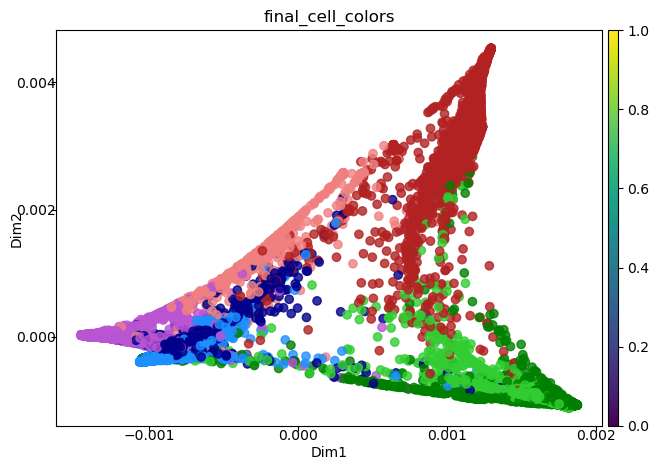

In [35]:
leiden_color_dict = {
    'ActB-1': 'lightskyblue',     # light blue cluster at bottom
    'ActB-2': 'dodgerblue',       # darker blue cluster
    'ActB-4': 'mediumorchid',     # purple cluster
    'GC-1': 'limegreen',          # bright green cluster
    'ActB-3': 'darkblue',         # dark blue cluster
    'Naive': 'darkgray',          # gray cluster on left
    'GC-2': 'green',              # darker green cluster
    'PB-2': 'firebrick',          # red cluster
    'earlyPB': 'lightcoral',      # pink/coral cluster
    'earlyActB': 'teal'           # teal cluster
}

# Create a new column in adata.obs for colors
adata.obs['final_cell_colors'] = adata.obs['sub_cell_type'].map(leiden_color_dict)

# Now plot using this new column
st.plot_dimension_reduction(adata, color=['final_cell_colors'], n_components=2)

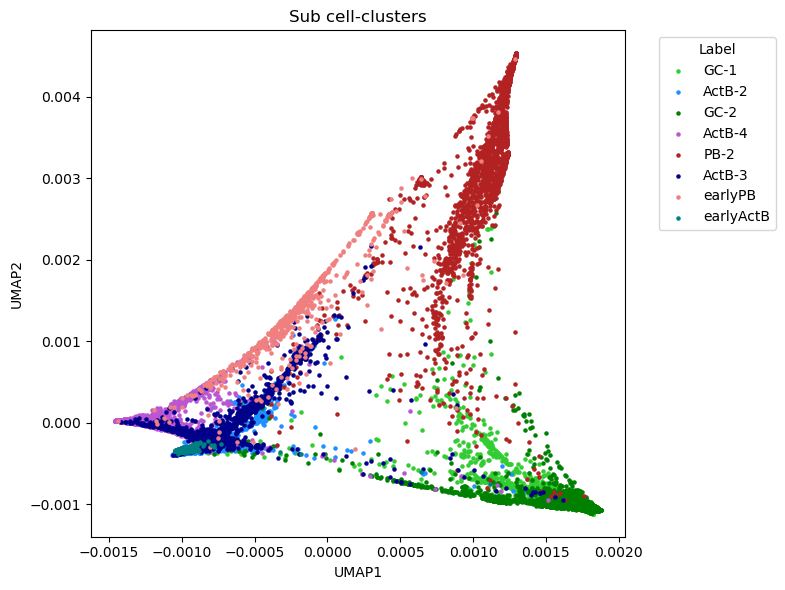

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring
labels = adata.obs['sub_cell_type']

# Get unique labels and their corresponding colors
unique_labels = labels.unique()
color_list = [leiden_color_dict[label] for label in unique_labels]

# Plotting the UMAP with colors based on labels
plt.figure(figsize=(8, 6))

for label, color in zip(unique_labels, color_list):
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=color, label=label, s=5)  # s=5 sets the marker size to 5 points

plt.title('Sub cell-clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualize selected cells on the trajectory
### Plot days of cells on trajectory embeddings

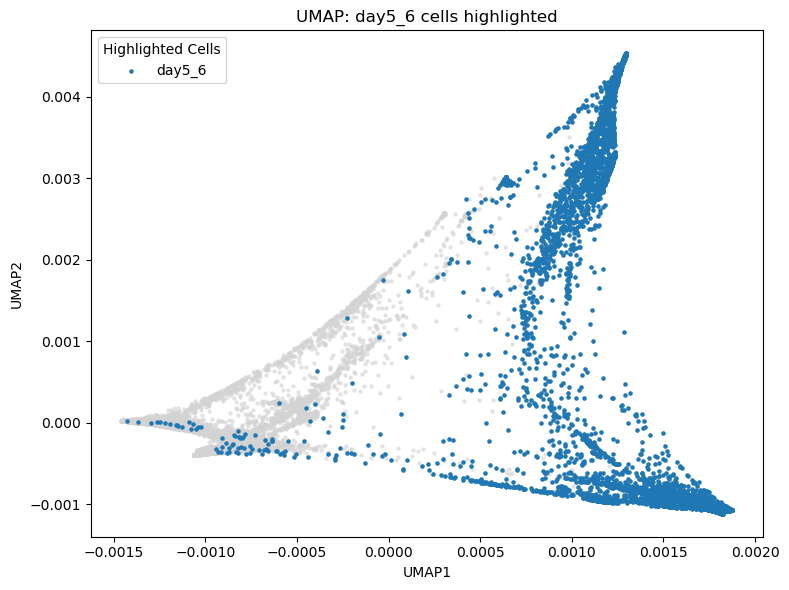

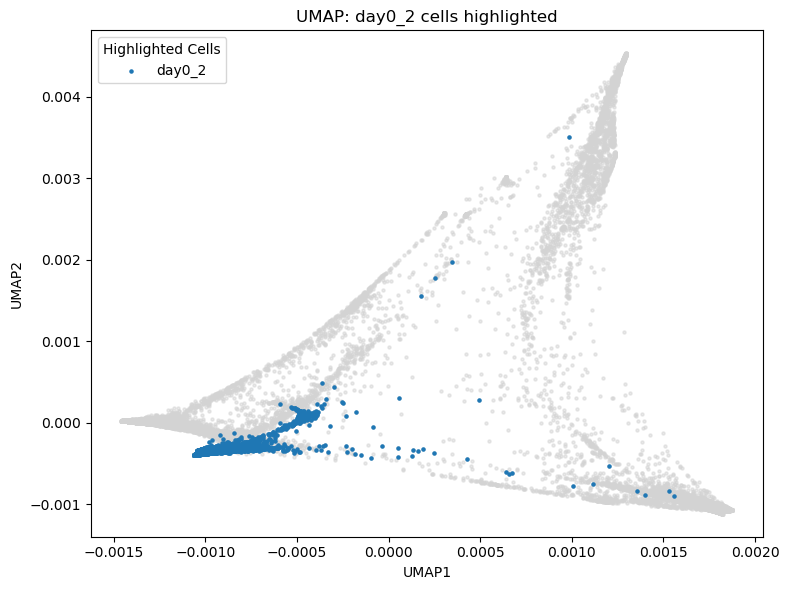

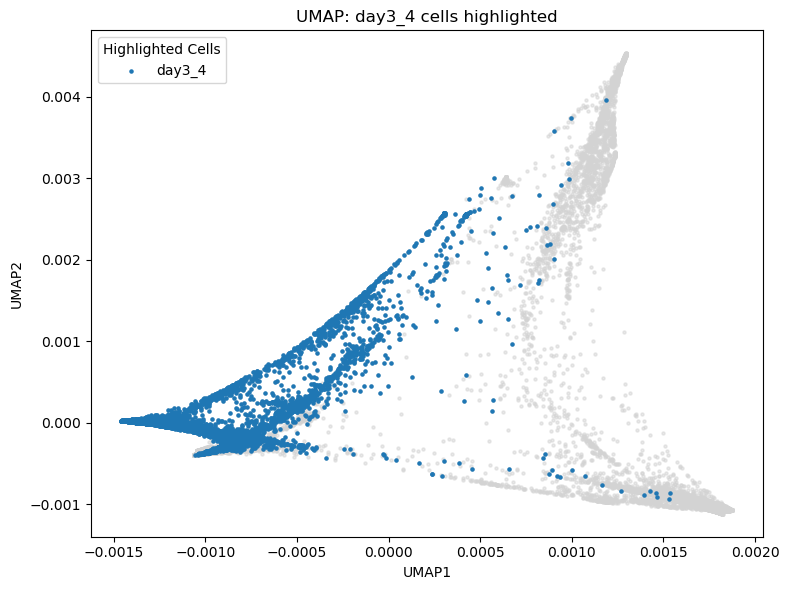

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring
labels = adata.obs['cell_type_major']

# Get unique labels
unique_labels = labels.unique()

# Define a color for the highlighted cells and for the background cells
highlight_color = '#1f77b4'  # A shade of blue
background_color = '#D3D3D3'  # Light gray

# Create a plot for each unique label
for label in unique_labels:
    plt.figure(figsize=(8, 6))
    
    # Plot background (gray) points first
    plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c=background_color, s=5, alpha=0.5)
    
    # Plot highlighted points
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=highlight_color, s=5, label=label)

    plt.title(f'UMAP: {label} cells highlighted')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title="Highlighted Cells", loc='upper left')
    plt.tight_layout()
    plt.show()

### Plot predicted cells commiting to each state from perturb-seq data and SLIDE analysis

In [38]:
# load cell barcodes from perturb-seq data and SLIDE analysis
day2_cells = ['D2_per_BATF.csv', 'D2_per_IRF4.csv', 'D2_per_SPIB.csv', 'D2_per_PRDM1.csv', 'D2_per_IRF8.csv']
day4_cells = ['D4_per_BATF.csv', 'D4_per_IRF4.csv', 'D4_per_SPIB.csv', 'D4_per_PRDM1.csv', 'D4_per_IRF8.csv']   

# Function to read CSV and add perturbation column
def read_csv_with_perturbation(filename):
    df = pd.read_csv(os.path.join(barcodes_dir, filename))
    perturbation = filename.split('.')[0]  # Remove .csv
    df['Perturbation'] = perturbation
    return df

# Read and combine day2 cells
day2_cells_df = pd.concat([read_csv_with_perturbation(file) for file in day2_cells], ignore_index=True)
day4_cells_df = pd.concat([read_csv_with_perturbation(file) for file in day4_cells], ignore_index=True)

# Rename the first column to 'Barcode'
day2_cells_df = day2_cells_df.rename(columns={day2_cells_df.columns[0]: 'Barcode'})
day4_cells_df = day4_cells_df.rename(columns={day4_cells_df.columns[0]: 'Barcode'})

display(day2_cells_df)
display(day4_cells_df)

,Barcode,x,Perturbation
0,AAACATGCACAGAAAC-1,-0.529038,D2_per_BATF
1,AAACCGAAGGACACTT-1,-0.197921,D2_per_BATF
2,AAACCGAAGTCATGCG-1,-0.293773,D2_per_BATF
3,AAACCGGCACAGAACG-1,-0.470738,D2_per_BATF
4,AAACCGGCAGGCGAGT-1,-0.436003,D2_per_BATF
...,...,...,...
3784,TTTGAGTCAAAGCGCA-1,0.351522,D2_per_IRF8
3785,TTTGCGGAGCAGGTGG-1,1.097622,D2_per_IRF8
3786,TTTGTCCCAAGGATTA-1,0.144348,D2_per_IRF8
3787,TTTGTTGGTAATAACC-1,0.324435,D2_per_IRF8


,Barcode,x,Perturbation
0,AAACGGATCGATATTG-2,-0.037349,D4_per_BATF
1,AAAGCAAGTGGTGAGA-2,-0.296665,D4_per_BATF
2,AACCGCTCAGATTCAT-2,-0.167110,D4_per_BATF
3,AACGCCCAGTTTGGTA-2,-0.083701,D4_per_BATF
4,AACGCTAGTAACCTAG-2,-0.388721,D4_per_BATF
...,...,...,...
3424,TTTGACCGTAGCTGGT-2,0.010884,D4_per_IRF8
3425,TTTGAGTCAGGCATGA-2,0.413497,D4_per_IRF8
3426,TTTGCGACAGCTCATA-2,0.247754,D4_per_IRF8
3427,TTTGTCTAGGCAGGTG-2,-0.020430,D4_per_IRF8


In [39]:
# add 10 new fields to adata.obs named the Perturbation names and set them as categorical
day2_perturbations = day2_cells_df['Perturbation'].unique()
day4_perturbations = day4_cells_df['Perturbation'].unique()
all_perturbations = np.concatenate([day2_perturbations, day4_perturbations])

# Create a dictionary for each perturbation mapping barcodes to perturbation names
perturbation_maps = {}
for pert in day2_perturbations:
    barcodes = day2_cells_df[day2_cells_df['Perturbation'] == pert]['Barcode']
    perturbation_maps[pert] = dict.fromkeys(barcodes, pert)
    
for pert in day4_perturbations:
    barcodes = day4_cells_df[day4_cells_df['Perturbation'] == pert]['Barcode']
    perturbation_maps[pert] = dict.fromkeys(barcodes, pert)

# Add a column for each perturbation
for pert in all_perturbations:
    adata.obs[pert] = adata.obs.index.map(perturbation_maps[pert])
    # Convert to categorical with NA for missing values
    adata.obs[pert] = adata.obs[pert].astype('category')

# Verify the results
print("\nSample of cells with their perturbation assignments:")
display(adata.obs[all_perturbations].head())

# Print some statistics
print("\nNumber of cells assigned to each perturbation:")
for pert in all_perturbations:
    n_cells = adata.obs[pert].notna().sum()
    print(f"{pert}: {n_cells} cells")


Sample of cells with their perturbation assignments:


,D2_per_BATF,D2_per_IRF4,D2_per_SPIB,D2_per_PRDM1,D2_per_IRF8,D4_per_BATF,D4_per_IRF4,D4_per_SPIB,D4_per_PRDM1,D4_per_IRF8
AAACAGCCAAGCCACT-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGCCAAGGTGCA-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGCCATTCAGCA-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACATGCAAAGCTCC-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACATGCACACAATT-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Number of cells assigned to each perturbation:
D2_per_BATF: 609 cells
D2_per_IRF4: 820 cells
D2_per_SPIB: 465 cells
D2_per_PRDM1: 1242 cells
D2_per_IRF8: 653 cells
D4_per_BATF: 447 cells
D4_per_IRF4: 803 cells
D4_per_SPIB: 271 cells
D4_per_PRDM1: 1267 cells
D4_per_IRF8: 641 cells


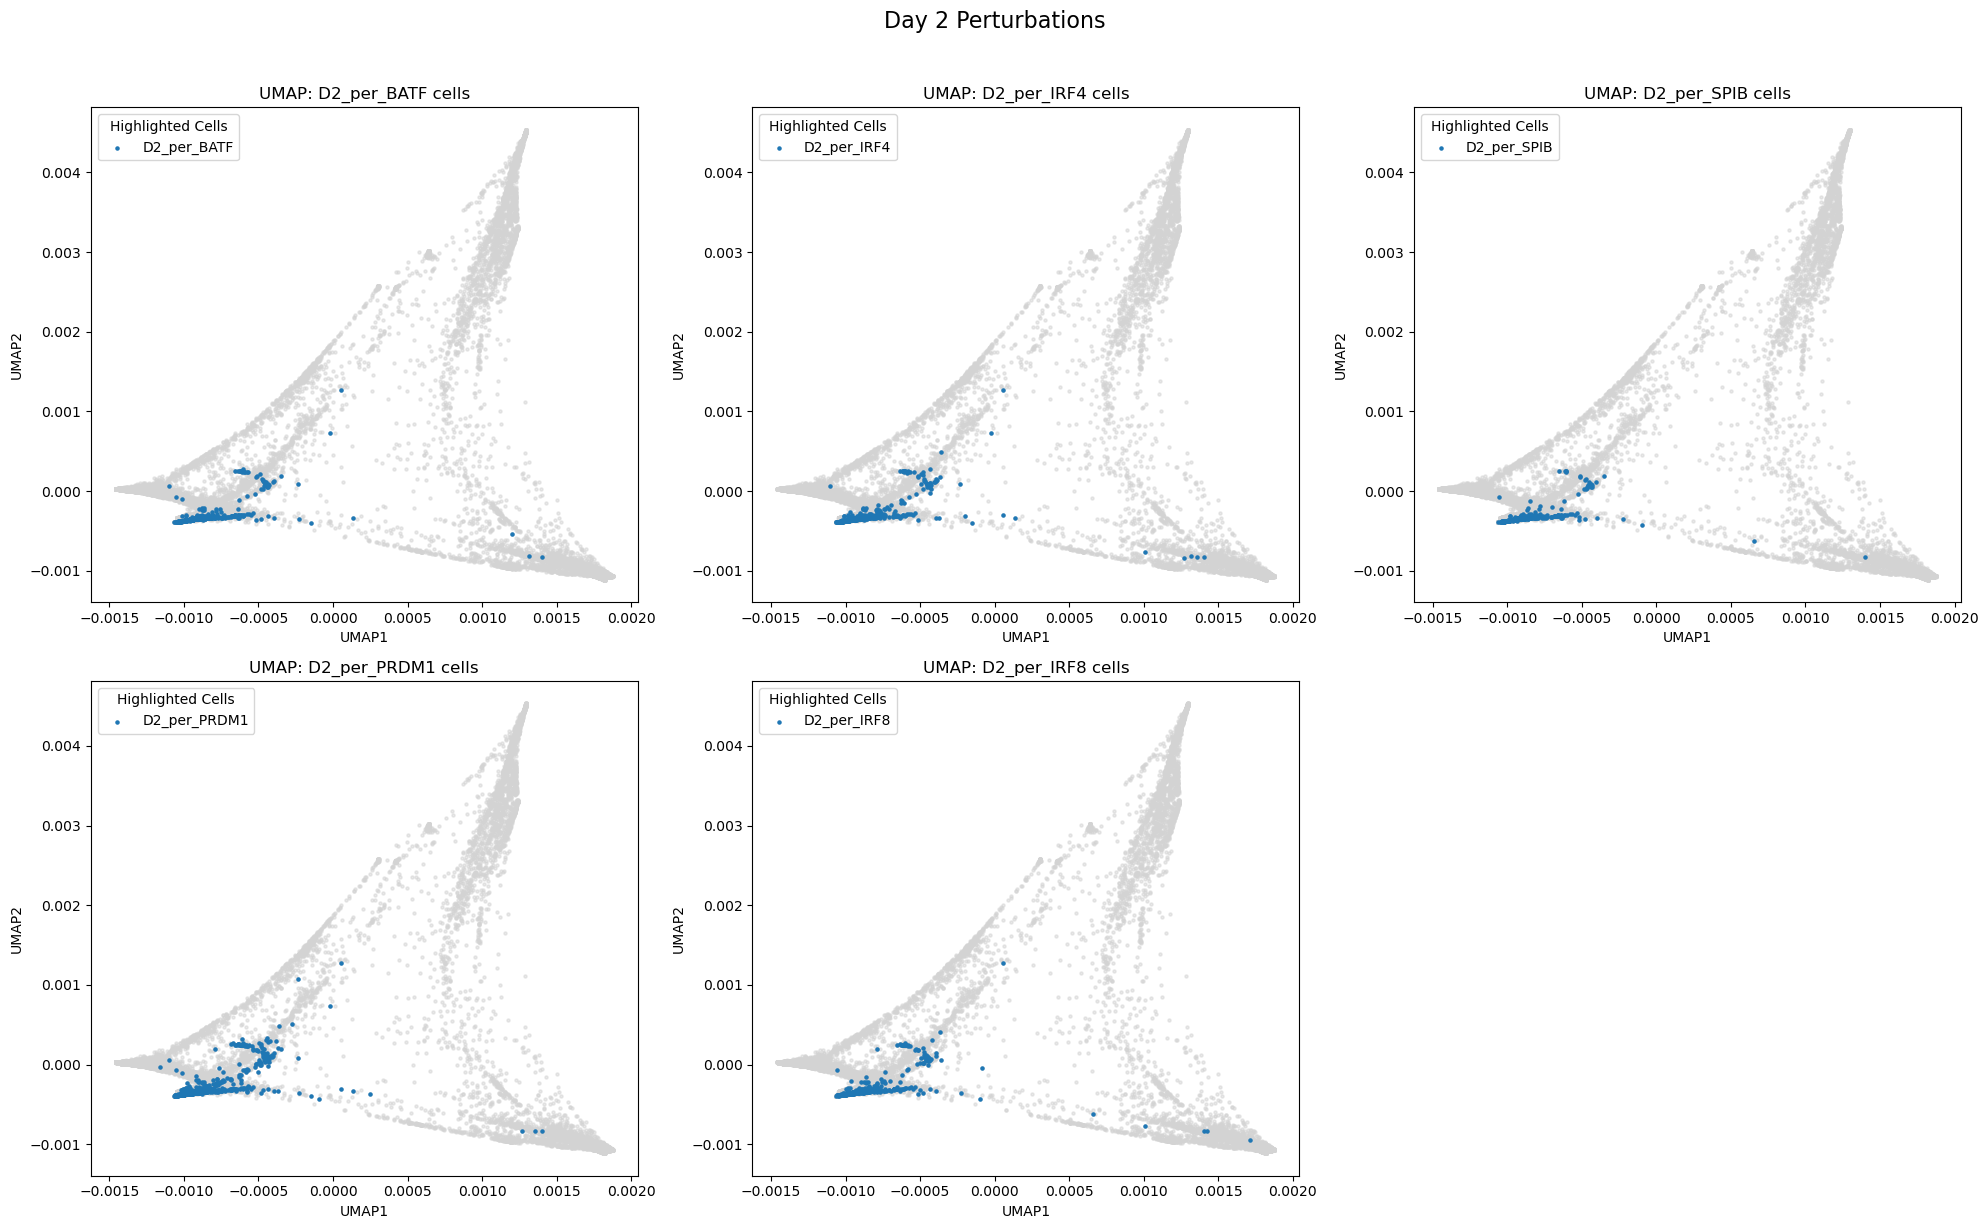

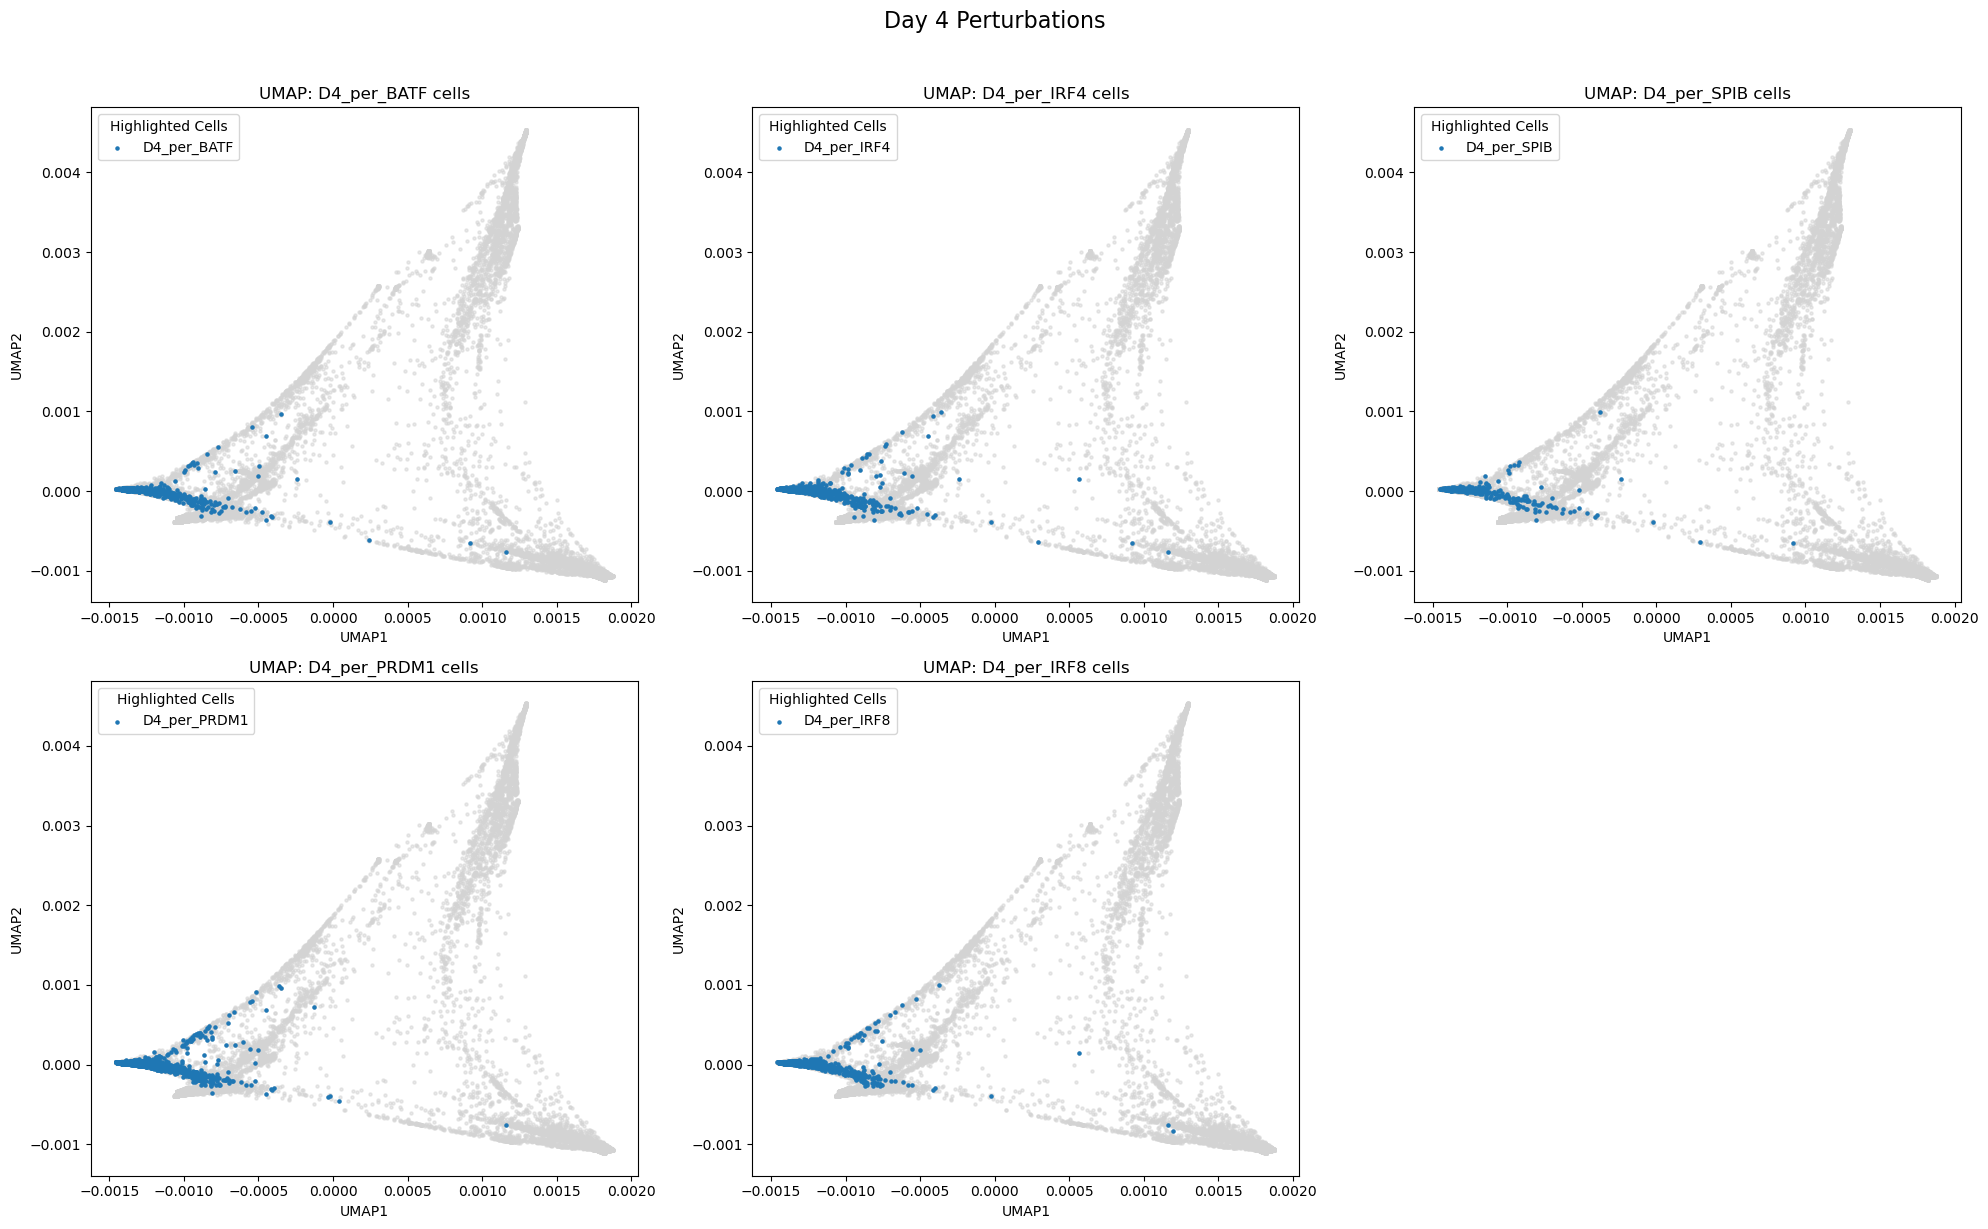


Number of cells in each perturbation:
D2_per_BATF: 609 cells
D2_per_IRF4: 820 cells
D2_per_SPIB: 465 cells
D2_per_PRDM1: 1242 cells
D2_per_IRF8: 653 cells
D4_per_BATF: 447 cells
D4_per_IRF4: 803 cells
D4_per_SPIB: 271 cells
D4_per_PRDM1: 1267 cells
D4_per_IRF8: 641 cells


In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_dr']

# Separate day2 and day4 perturbations
day2_perturbations = [pert for pert in all_perturbations if pert.startswith('D2_')]
day4_perturbations = [pert for pert in all_perturbations if pert.startswith('D4_')]

# Define colors
highlight_color = '#1f77b4'  # A shade of blue
background_color = '#D3D3D3'  # Light gray

# Create plots for Day 2 perturbations
plt.figure(figsize=(20, 12))
for i, pert in enumerate(day2_perturbations, 1):
    plt.subplot(2, 3, i)
    
    # Plot background (gray) points first
    plt.scatter(umap_coords[:, 0], umap_coords[:, 1], 
               c=background_color, s=5, alpha=0.5)
    
    # Plot highlighted points (cells with non-NA values for this perturbation)
    idx = adata.obs[pert].notna()
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], 
               c=highlight_color, s=5, label=pert)

    plt.title(f'UMAP: {pert} cells')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title="Highlighted Cells", loc='upper left')

plt.suptitle('Day 2 Perturbations', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Create plots for Day 4 perturbations
plt.figure(figsize=(20, 12))
for i, pert in enumerate(day4_perturbations, 1):
    plt.subplot(2, 3, i)
    
    # Plot background (gray) points first
    plt.scatter(umap_coords[:, 0], umap_coords[:, 1], 
               c=background_color, s=5, alpha=0.5)
    
    # Plot highlighted points (cells with non-NA values for this perturbation)
    idx = adata.obs[pert].notna()
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], 
               c=highlight_color, s=5, label=pert)

    plt.title(f'UMAP: {pert} cells')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title="Highlighted Cells", loc='upper left')

plt.suptitle('Day 4 Perturbations', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Print statistics
print("\nNumber of cells in each perturbation:")
for pert in all_perturbations:
    n_cells = adata.obs[pert].notna().sum()
    print(f"{pert}: {n_cells} cells")

## Trajectory inference by fitting elastic graph

In [41]:
import os
os.environ["OMP_NUM_THREADS"] = "64"
from tempfile import TemporaryDirectory
from rpy2.robjects import r
# Load the rlang package in R
r('library(rlang)')

# Parameters for STREAM (tune to your dataset)
ka1={'epg_alpha':0.02,'epg_mu':0.07,'epg_lambda':0.02,'epg_trimmingradius':2} # epg_mu needs to be tuned to get a good branch for day-1 to activated and undefined cells
ka2={'epg_ext_mode':'QuantDists','epg_ext_par':1.}

# Trajectory inference
with TemporaryDirectory() as td:
	st.set_workdir(adata,td)
	st.seed_elastic_principal_graph(adata,n_clusters=10)
	st.elastic_principal_graph(adata,**ka1)
	st.extend_elastic_principal_graph(adata,**ka2)
	

Saving results in: /tmp/tmp57hpr15i
Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 3
Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 23211 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||50
	
4.908e-08
	
50
	
49
	
46
	
1
	
0
	
0
	
1.826e-08
	
1.712e-08
	
0.9938
	
0.9942
	
2.816e-08
	
2.66e-09
	
1.33e-07
	
6.65e-06
	
0




/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)


70.876 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 3
Extending leaves with additional nodes ...
Number of branches after extending leaves: 3


In [42]:
st.optimize_branching(adata,incr_n_nodes=30) #smoothen out the branches

Optimizing branching...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 83 nodes on 23211 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
53
 
54
 
55
 
56
 
57
 
58
 
59
 
60
 
61
 
62
 
63
 
64
 
65
 
66
 
67
 
68
 
69
 
70
 
71
 
72
 
73
 
74
 
75
 
76
 
77
 
78
 
79
 
80
 
81
 
82
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||83
	
3.436e-08
	
83
	
82
	
79
	
1
	
0
	
0
	
1.414e-08
	
1.356e-08
	
0.9952
	
0.9954
	
1.884e-08
	
1.386e-09
	
1.15e-07
	
9.547e-06
	
0


8.314 sec elapsed

Number of branches after optimizing branching: 3


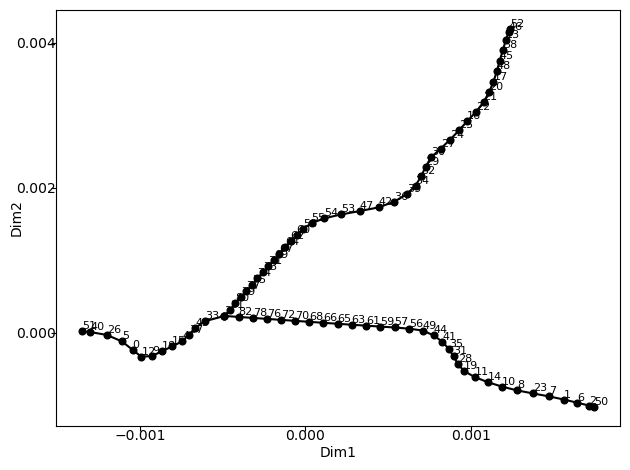

In [43]:
st.plot_branches(adata,show_text=True)

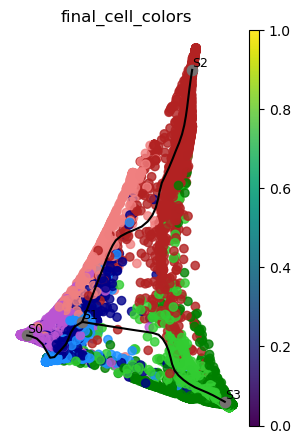

In [45]:
import matplotlib.pyplot as plt

st.plot_dimension_reduction(adata,show_graph=True,show_text=True,color=['final_cell_colors'])
ax=plt.gca()
ax.set_aspect(1)
ax.axis('off');


Extending leaves with additional nodes ...
Number of branches after extending leaves: 3


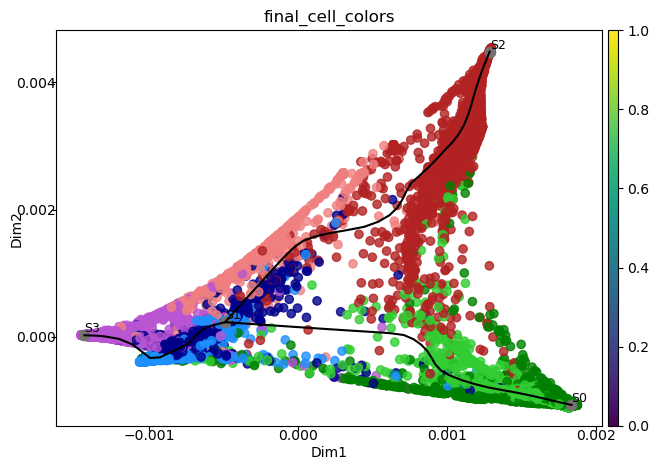

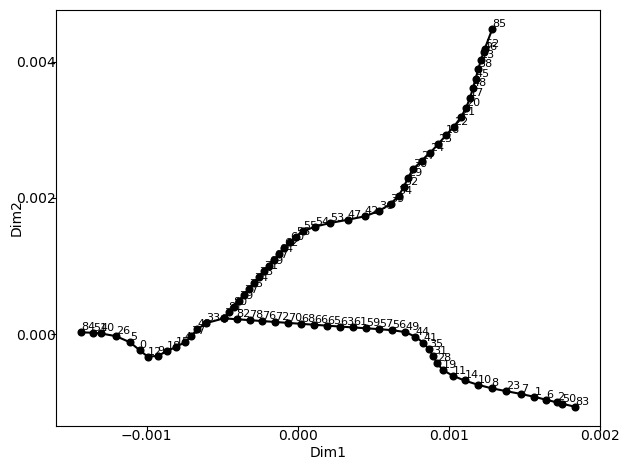

In [46]:
###Extend leaf branch to reach further cells 
st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=0.8)
st.plot_dimension_reduction(adata,color=['final_cell_colors'],n_components=2,show_graph=True,show_text=True)
st.plot_branches(adata,show_text=True)

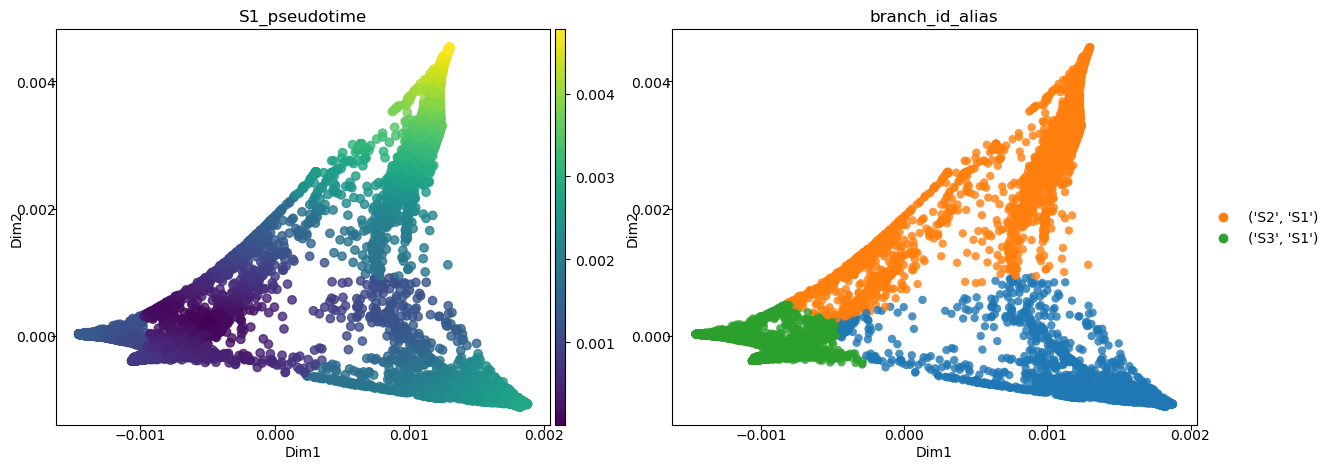

In [47]:
#Replace S3 with your own starting node if on a different dataset
st.plot_dimension_reduction(adata,color=['S1_pseudotime','branch_id_alias'])


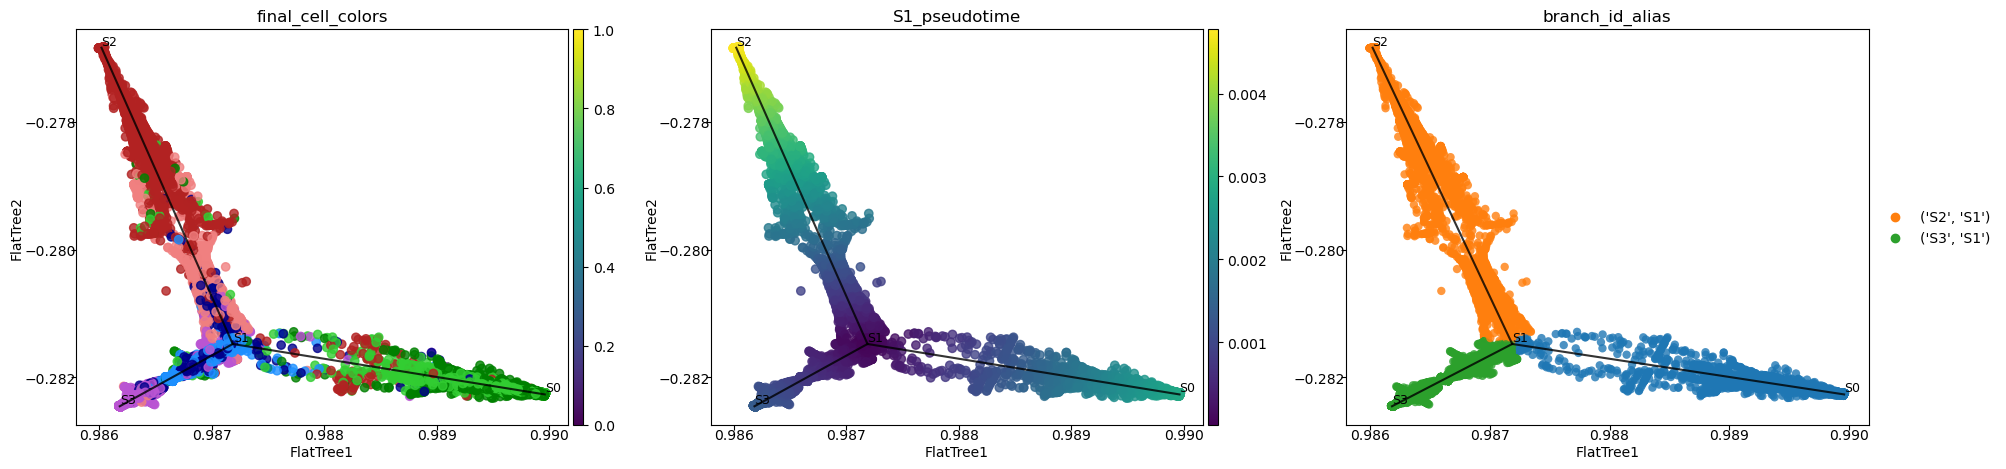

In [48]:
st.plot_flat_tree(adata,color=['final_cell_colors','S1_pseudotime','branch_id_alias'],
                  dist_scale=0.5,show_graph=True,show_text=True)


### Verifying genes of interest's expression per branch on the trajectory

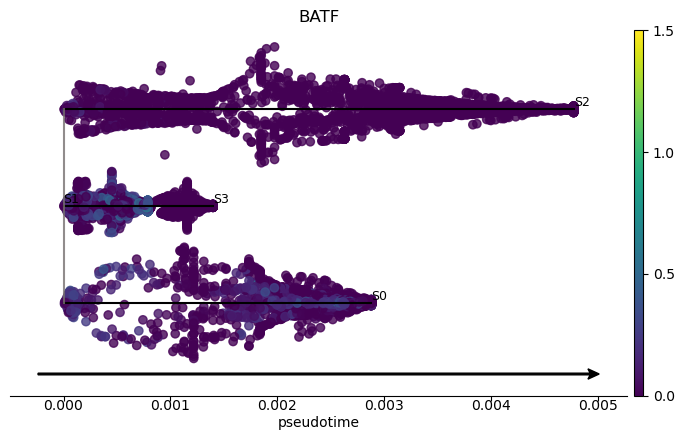

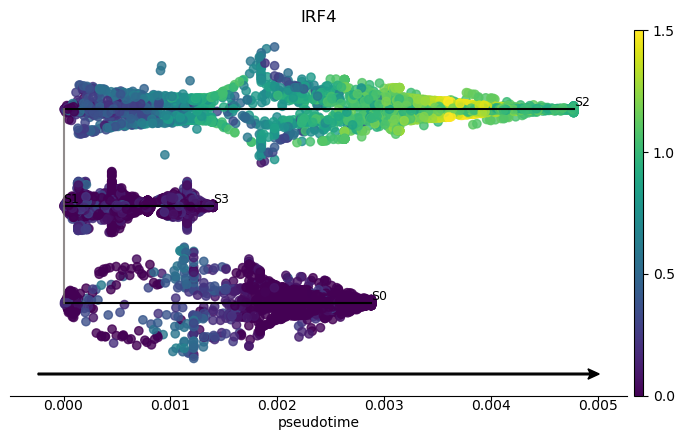

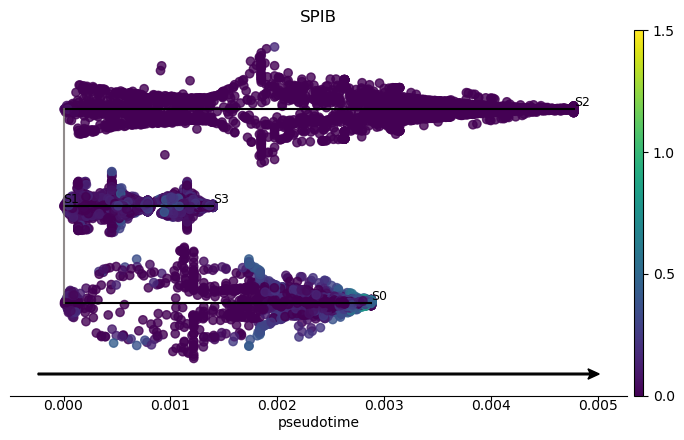

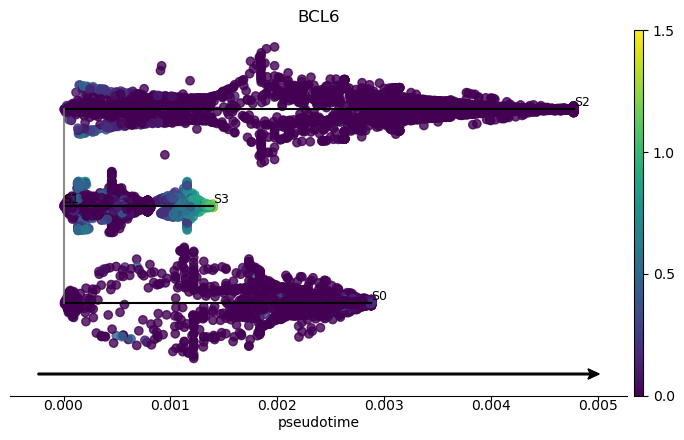

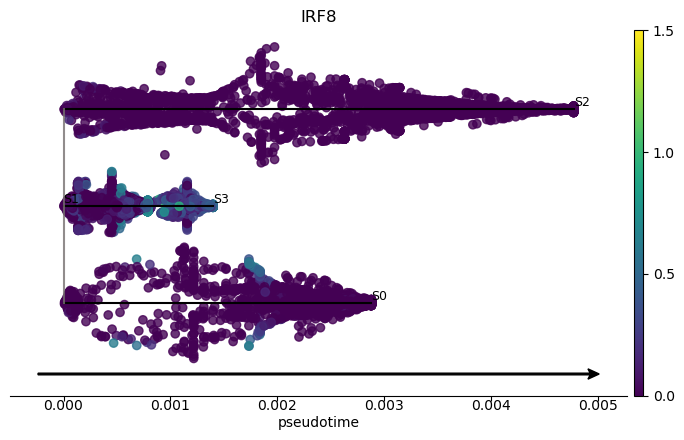

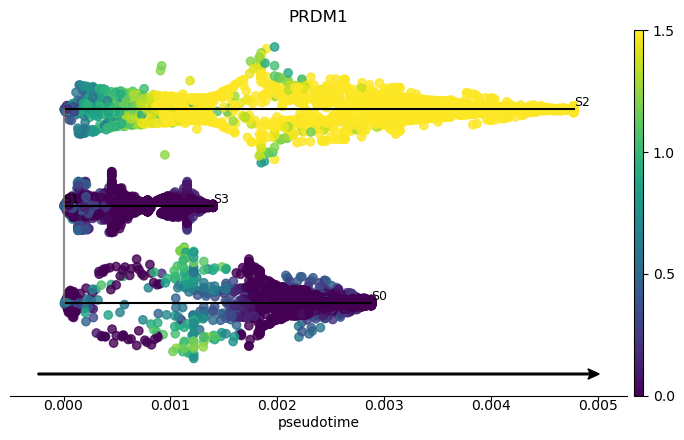

In [49]:
st.plot_stream_sc(adata,root='S1',color=['BATF','IRF4', 'SPIB', 'BCL6', 'IRF8', 'PRDM1'], vmin=0, vmax=1.5,dist_scale=0.3,show_graph=True,show_text=True)

In [50]:
adata.obs.head()

,cell_type_major,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,topic_0,topic_1,topic_2,topic_3,...,kmeans,node,branch_id,branch_id_alias,branch_lam,branch_dist,S0_pseudotime,S1_pseudotime,S3_pseudotime,S2_pseudotime
AAACAGCCAAGCCACT-3,day5_6,3582,3580,8281.0,846.0,10.216157,0.018575,0.013160,0.008065,0.036125,...,cluster 3,83,"(83, 3)","(S0, S1)",0.000013,0.000042,0.000013,0.002868,0.004267,0.007644
AAACAGCCAAGGTGCA-1,day0_2,2416,2415,4951.0,471.0,9.513230,0.038631,0.025551,0.318661,0.011544,...,cluster 0,12,"(84, 3)","(S3, S1)",0.000615,0.000041,0.003665,0.000784,0.000615,0.005560
AAACAGCCATTCAGCA-3,day5_6,4483,4477,11874.0,917.0,7.722755,0.017965,0.018262,0.013738,0.013966,...,cluster 3,6,"(83, 3)","(S0, S1)",0.000221,0.000022,0.000221,0.002661,0.004060,0.007437
AAACATGCAAAGCTCC-1,day0_2,2903,2903,6320.0,532.0,8.417722,0.018026,0.011716,0.045281,0.014255,...,cluster 0,12,"(84, 3)","(S3, S1)",0.000611,0.000043,0.003670,0.000788,0.000611,0.005564
AAACATGCACACAATT-3,day5_6,2238,2237,4395.0,234.0,5.324232,0.033269,0.075743,0.009055,0.023506,...,cluster 3,2,"(83, 3)","(S0, S1)",0.000147,0.000014,0.000147,0.002735,0.004134,0.007511


In [51]:
# save the S2_pseudotime with barcodes (taken from obs.index) to a csv
pseudotime_df = pd.DataFrame({'Barcode': adata.obs.index, 'S1_pseudotime': adata.obs['S1_pseudotime']})
pseudotime_df.to_csv(os.path.join(stream_outs_path,'S1_pseudotime.csv'), index=False)


In [52]:
# write stream result to pkl
st.write(adata,file_name=os.path.join(stream_outs_path,'stream_traj_v4.pkl'))

In [53]:
import numpy as np
import pandas as pd
# Extract node names from pseudotime columns
dimnodes=np.array(sorted([x[:-len('_pseudotime')] for x in adata.obs.columns if x.endswith('_pseudotime')]))
dist=np.array([adata.obs.loc[adata.obs.index,x+'_pseudotime'].values for x in dimnodes]).T
node_dict=dict(zip(dimnodes,range(len(dimnodes))))
branch = np.array([
    sorted([node_dict.get(y.strip('() \''), None) for y in x])
    for x in adata.obs['branch_id_alias']
])

# save the branch, edge, and dist files

# The branch each cell is on (cell:(node_start,node_end))
branch=pd.DataFrame(branch,index=adata.obs.index)
branch.to_csv(os.path.join(stream_outs_path,'branch.tsv.gz'),header=False,index=False,sep='\t')

# Identify and save unique edges between nodes
edge=np.unique(branch.values,axis=0)
edge=pd.DataFrame(edge)
edge.to_csv(os.path.join(stream_outs_path,'edge.tsv.gz'),header=False,index=False,sep='\t')

# The distance of each cell to each node (cell:node, value is pseudotime distance)
dist=pd.DataFrame(dist,index=adata.obs.index,columns=dimnodes)
dist.to_csv(os.path.join(stream_outs_path,'dist.tsv.gz'),header=True,index=True,sep='\t')

#### Make subsets of the sub cell types

In [55]:
adata.obs.sub_cell_type.to_csv(f'{dictys_data_path}/clusters.csv',header=['Cluster'],index=True,index_label='Barcode')


#### Make coord_rna.tsv.gz file of the cells and their lower dim coords, for dictys input

In [56]:
import anndata as ad
import pandas as pd

# Convert the obs.index (cell barcodes) to a DataFrame
obs_index_df = pd.DataFrame(adata.obs.index)
# Create a new AnnData object with only the cell barcodes and X_dr from obsm
adata_reduced = ad.AnnData(
    obs=obs_index_df,  # Use the cell barcodes as the obs DataFrame
    obsm={"X_dr": adata.obsm['X_dr']}  # Keep only 'X_dr' from obsm
)
# Confirm that the new AnnData object has the correct structure
adata_reduced

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 23211 × 0
    obs: 0
    obsm: 'X_dr'

In [57]:
import os
import pandas as pd

# Extract the relevant columns from the AnnData object
# The cell barcodes (obs.index) and 'X_dr' from obsm
cell_barcodes = adata.obs.index
xy_coords = adata_reduced.obsm['X_dr']

# Create a DataFrame with cell barcodes as the first column and 'X_dr' as the next columns
coord_df_b_cell = pd.DataFrame(data=xy_coords, columns=['x', 'y'])
coord_df_b_cell.insert(0, None, cell_barcodes)

#display the df
print(coord_df_b_cell.head())

                  NaN         x         y
0  AAACAGCCAAGCCACT-3  0.001805 -0.001100
1  AAACAGCCAAGGTGCA-1 -0.000983 -0.000371
2  AAACAGCCATTCAGCA-3  0.001632 -0.000983
3  AAACATGCAAAGCTCC-1 -0.001001 -0.000374
4  AAACATGCACACAATT-3  0.001714 -0.000987


In [58]:
# Save the DataFrame to a TSV file
output_path = os.path.join(dictys_data_path,'coord_rna.tsv.gz')
coord_df_b_cell.to_csv(output_path, sep='\t', compression='gzip', index=False, header=['', 'x', 'y'])